In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
from scipy.stats import chisquare
from PIL import Image
from __future__ import print_function
import torch
from torchvision import transforms as T
from torchvision import models

In [3]:
path_jpg = 'C:/Users/bolub/OneDrive/Masaüstü/Ders/Year_4/FYP/pad-ufes-20/images/imgs_process'
img_files = [x for x in os.listdir(path_jpg)]
print(img_files)

['PAT_100_393_595.png.jpg', 'PAT_109_868_113.png.jpg', 'PAT_109_868_723.png.jpg', 'PAT_1107_427_352.png.jpg', 'PAT_1109_436_141.png.jpg', 'PAT_1109_437_254.png.jpg', 'PAT_112_168_360.png.jpg', 'PAT_1138_520_154.png.jpg', 'PAT_1186_680_578.png.jpg', 'PAT_1216_759_542.png.jpg', 'PAT_1217_762_198.png.jpg', 'PAT_122_185_957.png.jpg', 'PAT_1245_844_471.png.jpg', 'PAT_1245_845_32.png.jpg', 'PAT_1252_866_852.png.jpg', 'PAT_1269_936_965.png.jpg', 'PAT_1273_952_89.png.jpg', 'PAT_1288_1003_969.png.jpg', 'PAT_1306_1086_124.png.jpg', 'PAT_1326_1156_139.png.jpg', 'PAT_1326_1156_783.png.jpg', 'PAT_1331_1173_380.png.jpg', 'PAT_1333_1177_434.png.jpg', 'PAT_1334_1178_413.png.jpg', 'PAT_1335_1181_21.png.jpg', 'PAT_1345_1223_175.png.jpg', 'PAT_1350_1230_878.png.jpg', 'PAT_1351_1231_203.png.jpg', 'PAT_1364_1246_143.png.jpg', 'PAT_1364_1246_238.png.jpg', 'PAT_1364_1246_420.png.jpg', 'PAT_1364_1246_447.png.jpg', 'PAT_1364_1246_583.png.jpg', 'PAT_1364_1246_927.png.jpg', 'PAT_1377_3512_370.png.jpg', 'PAT_1379

In [4]:
def preProcess(image):
    #Read the image and convert from BGR to RGB format
    img = cv.imread(image)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    #Resize the image
    img = cv.resize(img, (200, 200))
    
    #Apply the Gaussian Blur
    img_blur = cv.GaussianBlur(img, (9,9), 0)
    
    #Apply the Morphological Opening and Closing Operations
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(img_blur, cv.MORPH_OPEN, kernel)
    img_closed = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel)
    
    #Apply CLAHE
    gray = cv.cvtColor(img_closed, cv.COLOR_RGB2GRAY)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Thresholding operation
    _, threshold = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    
    # Morphological Opening and Closing
    kernel_2 = np.ones((5,5),np.uint8)
    opening_thresh = cv.morphologyEx(threshold, cv.MORPH_OPEN, kernel_2)
    threshold_closed = cv.morphologyEx(opening_thresh, cv.MORPH_CLOSE, kernel_2)
    
    # Find Contours
    contours, _ = cv.findContours(threshold_closed, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    #Sort the Contours and Define the largest one by areas        
    sorted_contours = sorted(contours, key=cv.contourArea, reverse=True)
    # Define the empty mask for contours
    mask = np.zeros(gray.shape, np.uint8)
    # Draw the contours on top of the mask, take the largest five
    cv.drawContours(mask, sorted_contours, 0, (255, 255, 255), -1)
    
    # Apply the mask to the original lesion image
    result = cv.bitwise_and(img, img, mask=mask)

    return result , sorted_contours

In [5]:
def drawMinAreaRect(image, contours):
    
    #draw minimum area rectangle around the contour
    rect = cv.minAreaRect(contours[0])
    
    #Get the angle of the rectangle with respect to bottom right point
    angle_rect = rect[2]
    actual_angle = 0
    
    #Check if the rectangle angle is lower than -45
    if abs(angle_rect) <= 45:
        actual_angle = abs(angle_rect)
    else:
        actual_angle = 90 - abs(angle_rect)
    
    #Define the four corners of the rectangle
    box = cv.boxPoints(rect)
    box = np.intp(box)
    
    #Get the center of the bounding rectangle for rotation matrix
    center_y = round(int(rect[0][1]))
    center_x = round(int(rect[0][0]))
    
    x_img, y_img = image.shape[:2]
    
    # Define the translation offsets
    tx = 100 - center_x
    ty = 100 - center_y
    
    # Define the transformation matrix
    M_translate  = np.array([
    [1, 0, tx],
    [0, 1, ty]
    ], dtype=np.float32)
    
    #Define the rotation matrix and necessary offsets, both for larger than 45 and smaller than 45
    M = cv.getRotationMatrix2D((center_x, center_y), actual_angle, 1)
    M2 = cv.getRotationMatrix2D((center_x, center_y), -actual_angle, 1)
    
    #Apply the rotation and transformation matrices to the image and the rectangle
    if angle_rect < 45:
        img_rot = cv.warpAffine(image, M, (x_img, y_img))
        img_rot_trans = cv.warpAffine(img_rot, M_translate, (x_img, y_img))
        box_rot = cv.transform(np.array([box]), M)
        box_rot_trans = cv.transform(box_rot, M_translate)
        img_plot = img_rot_trans
    else:
        img_rot = cv.warpAffine(image, M2, (x_img, y_img))
        img_rot_trans = cv.warpAffine(img_rot, M_translate, (x_img, y_img))
        box_rot = cv.transform(np.array([box]), M2)
        box_rot_trans = cv.transform(box_rot, M_translate)
        img_plot = img_rot_trans
    
    return img_rot_trans

1.9500000000000002

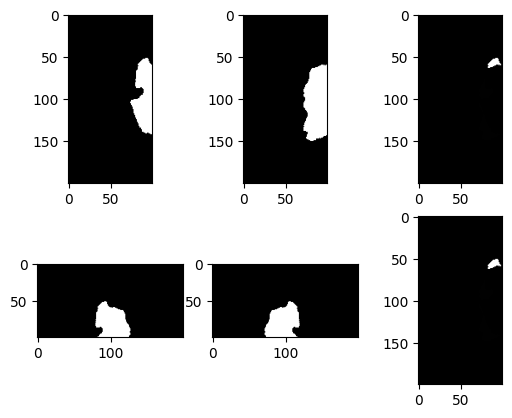

In [7]:
# Asymmetry Analysis

def find_asymmetry(rotated_image):
    gray_rotated_image = cv.cvtColor(rotated_image, cv.COLOR_RGB2GRAY)
    _ , thresh = cv.threshold(gray_rotated_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    
    # Get the image dimensions
    height, width = gray_rotated_image.shape
    
    # Calculate the histograms for colour asymmetry
    r,g,b = cv.split(rotated_image)
    hist_r_left = cv.calcHist([r[:,:width//2]], [0], None, [256], [0, 256])
    hist_g_left = cv.calcHist([g[:,:width//2]], [0], None, [256], [0, 256])
    hist_b_left = cv.calcHist([b[:,:width//2]], [0], None, [256], [0, 256])
    hist_r_right = cv.calcHist([r[:width//2,:]], [0], None, [256], [0, 256])
    hist_g_right = cv.calcHist([g[:width//2,:]], [0], None, [256], [0, 256])
    hist_b_right = cv.calcHist([b[:width//2,:]], [0], None, [256], [0, 256])
    
    # Get the Correlation Metric value of Histograms, for each channel
    metric_val_r = cv.compareHist(hist_r_left, hist_r_right, cv.HISTCMP_CORREL)
    metric_val_g = cv.compareHist(hist_g_left, hist_g_right, cv.HISTCMP_CORREL)
    metric_val_b = cv.compareHist(hist_b_left, hist_b_right, cv.HISTCMP_CORREL)
    metric = (metric_val_r + metric_val_g + metric_val_b)/3
    
    # Decide on the colour asymmetry score
    asymmetry_score_color = 0
    
    if metric < 0.1:
        asymmetry_score_color = 0
    elif metric > 0.1 and metric < 0.2:
        asymmetry_score_color = 1
    else:
        asymmetry_score_color = 2
    
    # Fold the image along the vertical axis
    left_half = thresh[:, :width // 2]
    right_half = np.flip(thresh[:, width // 2:], axis=1)
    folded_image_vertical = np.abs(left_half - right_half)
    
    #Fold the image along the horizontal axis
    top_half = thresh[:height // 2, :]
    bottom_half = np.flip(thresh[:height // 2,:], axis=1)
    folded_image_horizontal = np.abs(top_half - bottom_half)

    # Find non-zero pixel values in the folded image
    nonzero_pixels = rotated_image[np.nonzero(rotated_image)]
    nonzero_pixels_vertical = folded_image_vertical[np.nonzero(folded_image_vertical)]
    nonzero_pixels_horizontal = folded_image_horizontal[np.nonzero(folded_image_horizontal)]

    # Count the number of non-zero pixel values
    num_nonzero_pixels = len(nonzero_pixels)
    num_nonzero_pixels_vertical = len(nonzero_pixels_vertical)
    num_nonzero_pixels_horizontal = len(nonzero_pixels_horizontal)
    
    #Decide on the score for asymmetry
    asymmetry_pixels_shape = (((num_nonzero_pixels_horizontal*0.5) + (num_nonzero_pixels_vertical*0.5)) / num_nonzero_pixels)*100
    
    if asymmetry_pixels_shape < 5:
        asymmetry_score_shape = 0
    elif asymmetry_pixels_shape > 5 and asymmetry_pixels_shape < 10:
        asymmetry_score_shape = 1
    else:
        asymmetry_score_shape = 2
    
    # Get the final asymmetry score
    asymmetry_score = (asymmetry_score_shape + asymmetry_score_color)/2
    
    #Plot 
    
    plt.subplot(2,3,1), plt.imshow(left_half, cmap='gray')
    plt.xticks(), plt.yticks()
    plt.subplot(2,3,2), plt.imshow(right_half, cmap='gray')
    plt.xticks(), plt.yticks()
    plt.subplot(2,3,3), plt.imshow(folded_image_vertical, cmap='gray')
    plt.xticks(), plt.yticks()
    plt.subplot(2,3,4), plt.imshow(top_half, cmap='gray')
    plt.xticks(), plt.yticks()
    plt.subplot(2,3,5), plt.imshow(bottom_half, cmap='gray')
    plt.xticks(), plt.yticks()
    plt.subplot(2,3,6), plt.imshow(folded_image_vertical, cmap='gray')
    plt.xticks(), plt.yticks()
    
    # Return the final asymmetry score
    return asymmetry_score*1.3

input_var = path_jpg + '/' + img_files[0]

result, contours = preProcess(input_var)   
rot_img = drawMinAreaRect(result, contours)
find_asymmetry(rot_img)

0.6000000000000001

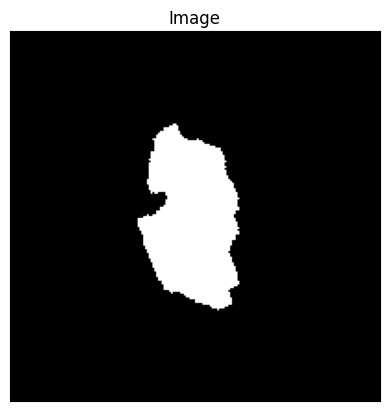

In [16]:
#Finding border irregularities

def find_border_irregularity(rotated_image):
    
    #Get dimensions of the image
    width = rotated_image.shape[1]
    height = rotated_image.shape[0]
    
    # Convert the image to grayscale
    gray_image = cv.cvtColor(rotated_image, cv.COLOR_BGR2GRAY)

    # Threshold the grayscale image to obtain a binary image
    _, binary_image = cv.threshold(gray_image, 0, 255, cv.THRESH_BINARY)
    
    # Find Contours
    contours, _ = cv.findContours(binary_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    #Sort the Contours and Define the largest one by areas        
    sorted_contours = sorted(contours, key=cv.contourArea, reverse=True)

    # Define a minimum enclosing circle
    (x, y), radius = cv.minEnclosingCircle(sorted_contours[0])
    center_circ = (int(x), int(y))
    radius = int(radius)
    cv.circle(rotated_image, center_circ, radius, (255, 0, 0), 2)
    
    # Define the translation offsets
    tx = 100 - center_circ[0]
    ty = 100 - center_circ[1]
    
    # Define the transformation matrix
    M_translate  = np.array([
    [1, 0, tx],
    [0, 1, ty]
    ], dtype=np.float32)
    
    #Shift the lesion to the center so that circle is aligned with each sector
    img_shifted = cv.warpAffine(binary_image, M_translate, (width, height))
    
    # Find Contours
    contours_shifted, _ = cv.findContours(img_shifted, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    sorted_shifted_contours = sorted(contours_shifted, key=cv.contourArea, reverse=True)
    
    #Calculate distance of each contour against the center of the circle
    dist_arr = []
    
    for i in range(len(sorted_shifted_contours[0])):
        contour_x = int(sorted_shifted_contours[0][i][0][0])
        contour_y = int(sorted_shifted_contours[0][i][0][1])
        dist = np.linalg.norm(np.array([100, 100]) - np.array([contour_x, contour_y]))
        dist_arr.append(dist)
    
    # Find the difference and hence, the score for all sectors
    sum_dist = sum(dist_arr)
    sum_circle = radius * int(len(dist_arr))
    dissimilarity_index = 1 - (sum_dist / sum_circle)
    
    # Decide border irregularity score
    border_score = 0
    
    if dissimilarity_index < 0.05:
        border_score = 0
    elif dissimilarity_index > 0.05 and dissimilarity_index < 0.1:
        border_score = 1
    elif dissimilarity_index > 0.1 and dissimilarity_index < 0.15:
        border_score = 2
    elif dissimilarity_index > 0.15 and dissimilarity_index < 0.2:
        border_score = 3
    elif dissimilarity_index > 0.2 and dissimilarity_index < 0.25:
        border_score = 4
    elif dissimilarity_index > 0.25 and dissimilarity_index < 0.3:
        border_score = 5
    elif dissimilarity_index > 0.3 and dissimilarity_index < 0.35:
        border_score = 6
    elif dissimilarity_index > 0.35 and dissimilarity_index < 0.4:
        border_score = 7
    elif dissimilarity_index > 0.4:
        border_score = 8

    # Calculate the center point
    center_x = int(width / 2)
    center_y = int(height / 2)

    # Define the line length (half of the image diagonal)
    line_length = int(np.sqrt(width**2 + height**2) / 2)

    # Create a blank canvas to draw the lines
    lines_canvas = np.zeros_like(img_shifted)

    # Calculate the start and end points for each line
    
    for i in range(4):
        end_x1 = center_x + int(line_length * np.cos(np.deg2rad(i * 90)))
        end_y1 = center_y + int(line_length * np.sin(np.deg2rad(i * 90)))
        
        end_x2 = center_x + int(line_length * np.cos(np.deg2rad((i * 90) + 45)))
        end_y2 = center_x + int(line_length * np.sin(np.deg2rad((i * 90) + 45)))

        # Draw the line on the canvas
        cv.line(lines_canvas, (center_x, center_y), (end_x1, end_y1), (0, 255, 0), 2)
        cv.line(lines_canvas, (center_x, center_y), (end_x2, end_y2), (0, 255, 0), 2)
            
        #Get the region of interest within the divided area
        xs = np.linspace(center_x, end_x1, 100)
        ys = np.linspace(center_y, end_y1, 100)
    
    # Overlay the lines on the original image
    overlaid_image = cv.addWeighted(img_shifted, 0.7, lines_canvas, 0.3, 0)

    # Display the original image with the lines
    plt.subplot(1,1,1), plt.imshow(overlaid_image, cmap="gray")
    plt.xticks([]), plt.yticks([]), plt.title("Image")
    
    
    return border_score*0.1

input_var = path_jpg + '/' + img_files[0]

result, contours = preProcess(input_var)   
rot_img = drawMinAreaRect(result, contours)
find_border_irregularity(rot_img)

In [10]:
# Check the color pixel of the lesions

def check_color(image_path):
    
    
    colour_codes = np.array([[1.0, 1.0, 1.0],[0.0, 0.0, 0.0],
                             [0.0, 0.0, 1.0],[0.25, 0.52, 0.80],
                             [0.13, 0.26, 0.40],[0.54, 0.52, 0.0]])
    count = np.array([0,0,0,0,0,0])
    
    img = cv.imread(image_path)
    img = cv.GaussianBlur(img, (5,5),0)
    img = cv.resize(img, (200, 200))
    
    #Set the thresholds for control, T for each pixel, L for the whole appearance of the colour
    L = 0.05
    T = 0.4
    score = 0
    
    #Loop through each pixel on the image
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            
            b = img[y,x,0] / 255
            g = img[y,x,1] / 255
            r = img[y,x,2] / 255
            
            for i in range(6):
                
                D = np.sqrt((b - colour_codes[i][0])**2 + (g - colour_codes[i][1])**2 + (r - colour_codes[i][2])**2)
                if D < T:
                    count[i] += 1
    
    percentages = count / (img.shape[0]*img.shape[1])
    
    for j in range(len(percentages)):
        if percentages[j] > L:
            score += 1
    
            
    return score*0.5, percentages

input_var = path_jpg + '/' + img_files[0]

result, contours = preProcess(input_var)   
rot_img = drawMinAreaRect(result, contours)
score, percentages = check_color(input_var)
print(score)
print(percentages)

1.0
[0.       0.0052   0.       0.856625 0.6334   0.      ]
